<a href="https://colab.research.google.com/github/hahaamg/Generative_AI/blob/main/MINST_%E7%AC%AC%E4%BA%8C%E9%80%B1%E4%BD%9C%E6%A5%AD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST 手寫字辨識 + Gradio
61372003H 孫睦桓

因為過去學習是使用 Pytorch 為主，因此這次的作業也是以 Pytorch 進行撰寫

模型方面則是使用 CNN 而非 Sequential 的 MLP

In [ ]:
import torch
from torch import nn
import torch.optim as optim
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


print(torchvision.__version__)

0.20.1+cu124


## 下載資料集
直接使用完整版的 MNIST 資料集

In [ ]:
# 訓練資料
train_data = datasets.MNIST(
    root="Data", # where to download data to?
    train=True, # 是否為訓練資料
    download=True,
    transform=ToTensor(), # PIL 轉 Torch tensors
    target_transform=None # ts?
)

# 測試資料
test_data = datasets.MNIST(
    root="Data",
    train=True, # 是否為訓練資料
    download=False,
    transform=ToTensor()
)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:11<00:00, 899kB/s] 


Extracting Data/MNIST/raw/train-images-idx3-ubyte.gz to Data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 65.3kB/s]


Extracting Data/MNIST/raw/train-labels-idx1-ubyte.gz to Data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]


Extracting Data/MNIST/raw/t10k-images-idx3-ubyte.gz to Data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.96MB/s]


Extracting Data/MNIST/raw/t10k-labels-idx1-ubyte.gz to Data/MNIST/raw



訓練和測試資料皆 6 萬筆

In [ ]:
len(train_data), len(test_data)

(60000, 60000)

## 檢查資料格式

看看資料的樣子，以下為第一筆訓練資料

In [ ]:
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [ ]:
image.size() # （通道數, 高度, 寬度） (C, H, W)

torch.Size([1, 28, 28])

查看資料的類別名稱

In [ ]:
class_name = train_data.classes
class_name

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

### 圖像展示資料

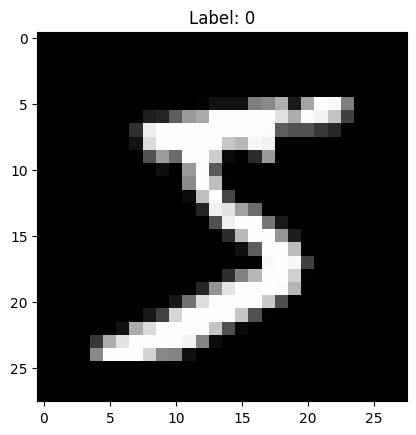

In [ ]:
# import os
# os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE" #我的筆電端使用有衝突才加入此行

plt.imshow(image.squeeze(), cmap="gray") #用 squeeze() 把 (1, 28, 28) 變成 (28, 28)，符合 Matplotlib 格式要求
plt.title(f"Label: {label}")
plt.show()


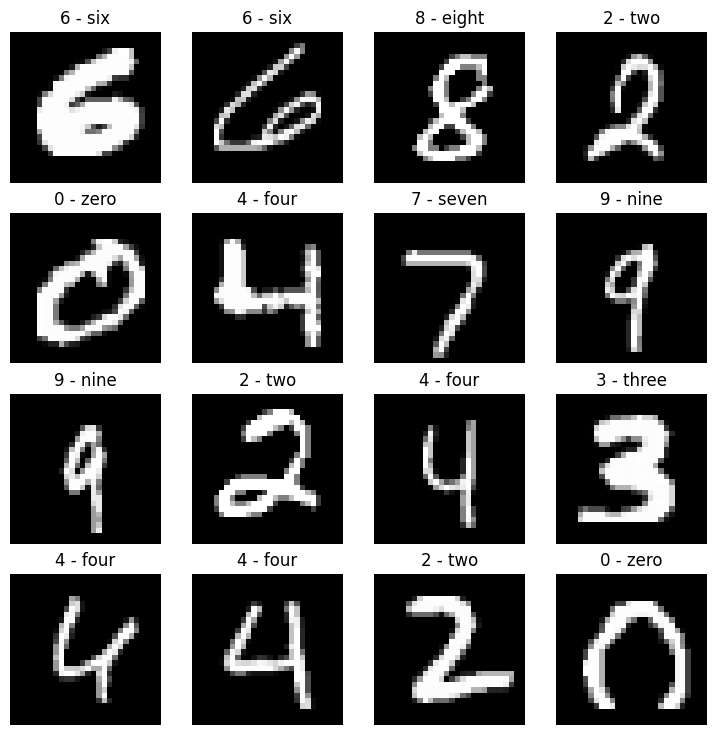

In [ ]:
# 參考過去的教學講義
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4


for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item() #隨機選擇數字
  img, label = train_data[random_idx] #隨機找訓練資料
  fig.add_subplot(rows, cols, i) #新增子圖
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_name[label])
  plt.axis(False)

### 設定 Dataloader
因為筆電效能有限，我一次的批量是設定 32 ，或是在 colab 可以設定更高

大概會被分為 1875 個 batches

In [ ]:
BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}...")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}...")

Length of train_dataloader: 1875 batches of 32...
Length of test_dataloader: 1875 batches of 32...


## 建立 CNN 模型
之前的 Python 課程中有學習建立 CNN 模型，也曾練習運用在 Fashion MNIST 中，故此次直接使用過去建立的 CNN 模型

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
from torch.nn import Flatten

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # 卷積層 卷積層學習局部特徵
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  #3x3 提取局部特徵 padding 擴充擷取邊緣資訊
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # 每 2x2 的區域取最大值，進行降維，減少計算量並提取重要特徵。 輸出尺寸：輸入尺寸會縮小一半。例如，如果輸入特徵圖是 28x28，經過池化後變為 14x14
        self.flatten = Flatten() # 卷積層和全連接層的輸入格式不同，Flatten 負責將局部特徵展平，將其轉換為全連接層可以處理的格式
        #全連接層 全連接層學習全局特徵
        self.fc1 = nn.Linear(64 * 14 * 14, 128)  # 根據特徵圖尺寸修改
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.relu(self.conv1(x)) # 第一個卷積 + ReLU
        x = self.pool(self.relu(self.conv2(x)))  # 第二個卷積 + ReLU + 池化
        x = self.flatten(x)  # 自動展平
        x = self.dropout(self.relu(self.fc1(x))) # 第一個全連接層 + ReLU + Dropout
        x = self.fc2(x) # 第二個全連接層（輸出分類結果）
        return x


model = CNN().to(device)
model

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=12544, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
)

## 訓練模型

In [ ]:
#參考之前的講義

criterion = nn.CrossEntropyLoss() #損失函數用交叉熵，之前 Fashion MNIST 也是使用這個損失函數
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_dataloader)}")

Epoch 1/10, Loss: 0.1569250258240228
Epoch 2/10, Loss: 0.05458490639864467
Epoch 3/10, Loss: 0.03890105013657982
Epoch 4/10, Loss: 0.031584994343051224
Epoch 5/10, Loss: 0.02389638345372417
Epoch 6/10, Loss: 0.018013142414126194
Epoch 7/10, Loss: 0.015252798589408728
Epoch 8/10, Loss: 0.013982457424512875
Epoch 9/10, Loss: 0.010545111040334237
Epoch 10/10, Loss: 0.01194719014341287


## 模型評估

In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total:.2f}%")

Accuracy: 99.87%


## 使用 Gradio

In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 109.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.4 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
import gradio as gr
import numpy as np
from PIL import Image

這邊遇到的問題是：Gradio Sketchpad 的輸入格式與 CNN 不同

CNN 需要的輸入是：` [1, 1, 28, 28] [batch, channels, height, width]`

老師原本 resize_image 輸出是` [1, 784]`

改良方式：
* 避免拉平成 [1, 784]，而是保持 [28, 28]。
* 增加通道維度，從 (28, 28) 變成 (1, 28, 28)（增加一個維度）。
* 增加 batch 維度，從 (1, 28, 28) 變成 (1, 1, 28, 28)

一開始沒有發現維度輸入的問題，這邊有請 ChatGPT 幫忙正規化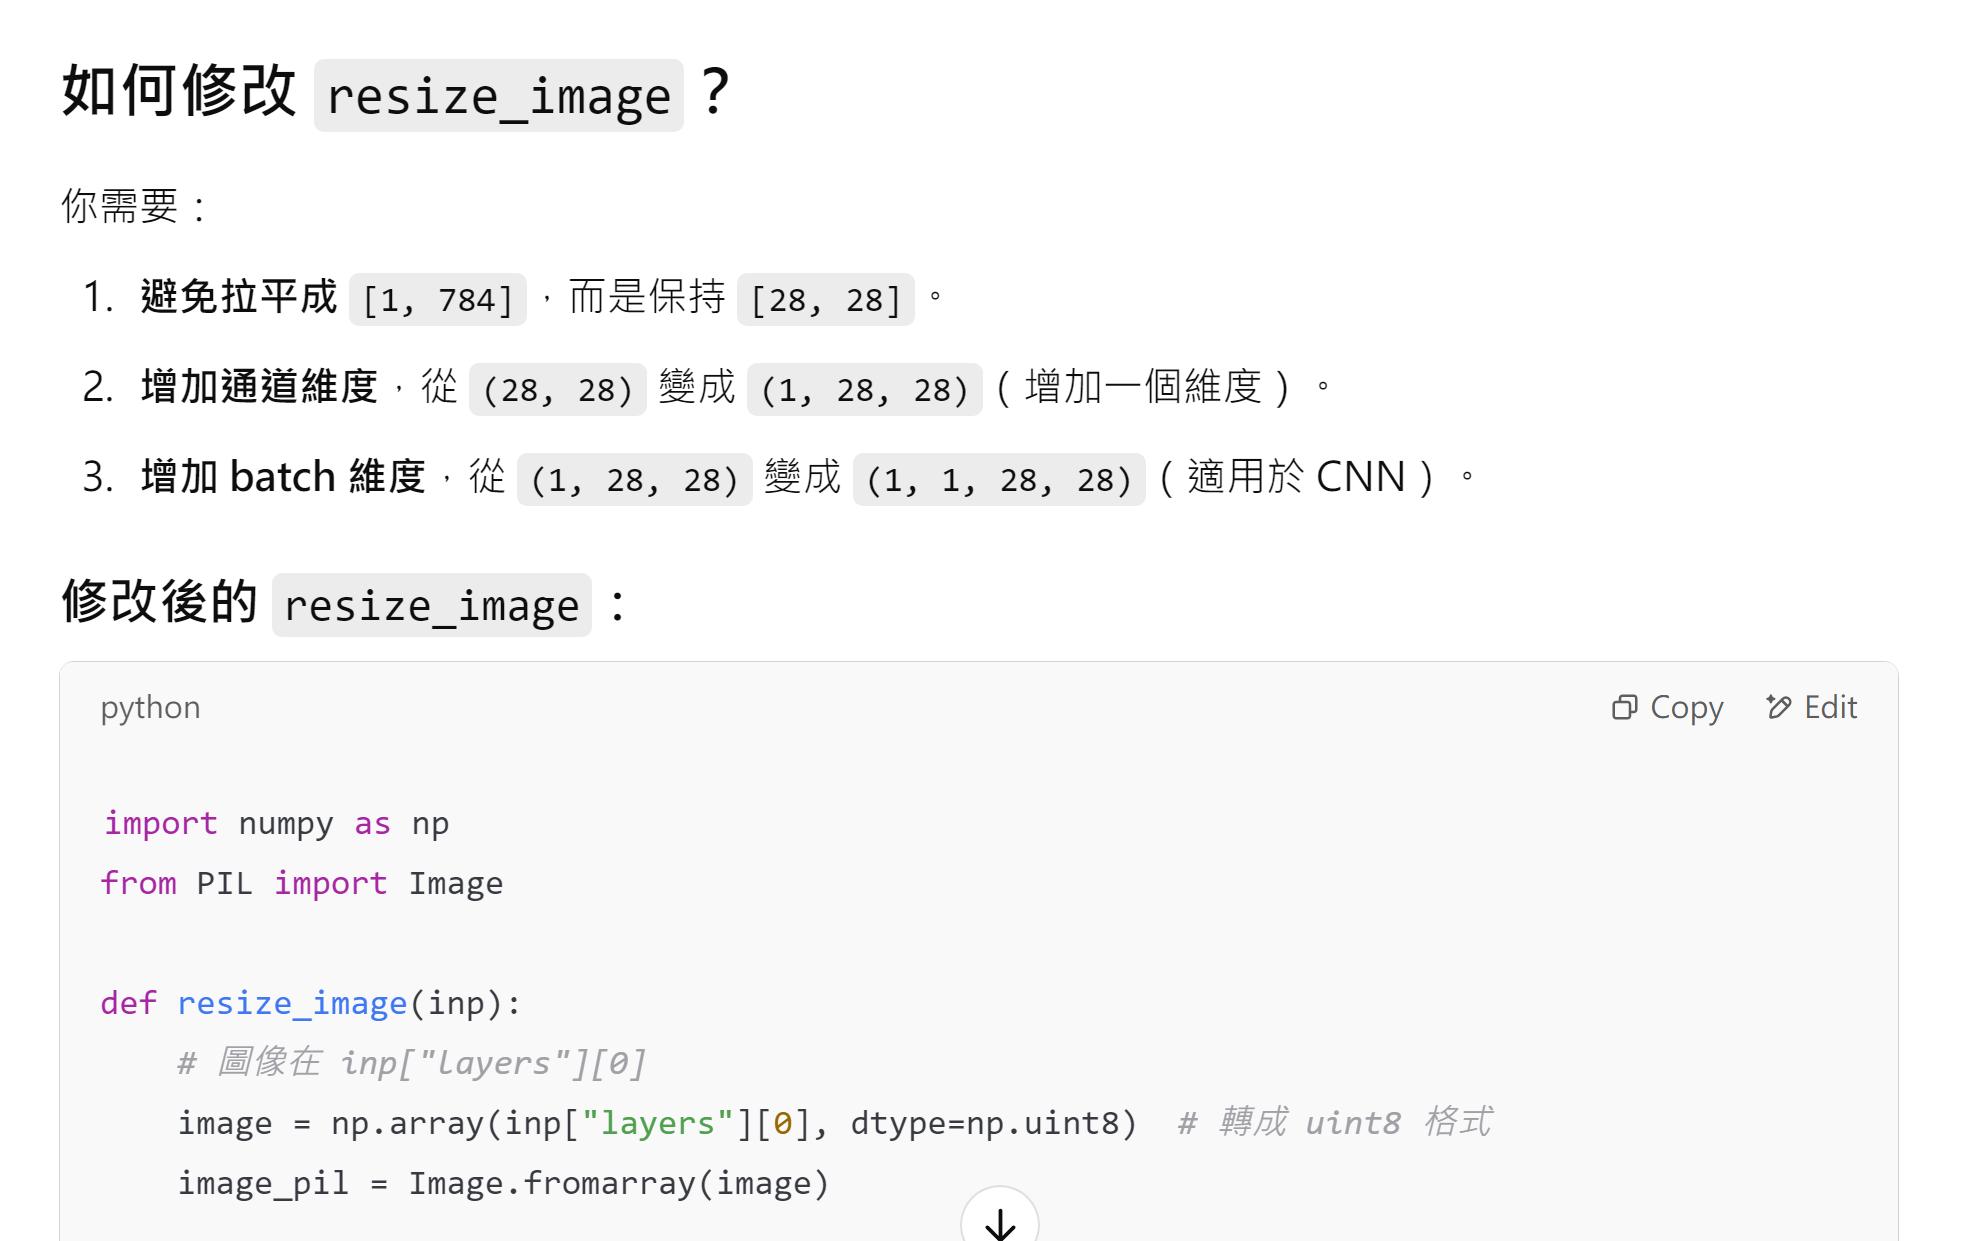

In [ ]:
import numpy as np
import torch
from PIL import Image

def resize_image(inp):
    # 圖像在 inp["layers"][0]
    image = np.array(inp["layers"][0], dtype=np.uint8)  # 轉成 uint8 格式
    image_pil = Image.fromarray(image)

    # 如果有透明通道，轉換為白色背景的 RGB
    if image_pil.mode == "RGBA":
        background = Image.new("RGB", image_pil.size, (255, 255, 255))
        background.paste(image_pil, mask=image_pil.split()[3])  # 使用透明通道作為遮罩
        image_pil = background

    # 轉換為灰階圖像
    image_gray = image_pil.convert("L")

    # 縮放到 28x28 並轉成 numpy 陣列
    img_array = np.array(image_gray.resize((28, 28), resample=Image.LANCZOS))

    # 配合 MNIST 格式，將顏色反轉（白底黑字 -> 黑底白字）
    img_array = 255 - img_array

    # 正規化並增加維度 (28, 28) → (1, 28, 28) → (1, 1, 28, 28)
    img_array = img_array.astype(np.float32) / 255.0  # 正規化到 [0,1]
    img_array = np.expand_dims(img_array, axis=0)  # (28,28) → (1,28,28)
    img_array = np.expand_dims(img_array, axis=0)  # (1,28,28) → (1,1,28,28)

    # 轉換成 PyTorch Tensor
    img_tensor = torch.tensor(img_array, dtype=torch.float32).to(device)

    return img_tensor


In [ ]:
import torch

def recognize_digit(inp):
    # 使用前面定義的 resize_image 函數處理圖像
    img_tensor = resize_image(inp)

    # 確保模型處於評估模式
    model.eval()

    # 使用模型進行預測，不計算梯度
    with torch.no_grad():
        output = model(img_tensor).to(device)
        probabilities = torch.nn.functional.softmax(output, dim=1)  # 計算 softmax

    # 獲取概率值
    probabilities = probabilities.cpu().numpy().flatten()  # 搬到 CPU，再將 tensor 轉為 numpy array
    labels = list('0123456789')
    return {labels[i]: float(probabilities[i]) for i in range(10)}


In [ ]:
iface = gr.Interface(
    fn=recognize_digit,
    inputs=gr.Sketchpad(),
    outputs=gr.Label(num_top_classes=3),
    title="MNIST 手寫辨識",
    description="請在畫板上繪製數字"
)

iface.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://e6c82d020d1492fb01.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://e6c82d020d1492fb01.gradio.live
